# The COVID-19 pandemic

This notebook uses the NYT github repository to analyze the progression of COVID-19 throughout the US states. **The analyses contained herein are not meant to be used as primary literature on their own, and may have mistakes**. I make no claims as to the accuracy of my calculations.

The questions I am interested in asking regarding this pandemic are fairly straightforward:
    * What is the case fatality rate through time?
    * What do the case / death curves look through time?
    * Are the curves flattening?

I have used the 2019 population census projections to normalize data by population, and I also used the census bureau areas to compute population density.

To compute per-day difference, I was originally using a `savgol_filter` as implemented by scipy. As of April 26, 2020, I am using a Gaussian Kernel smoother with a 2 standard deviation bandwidth.

In [1]:
import datetime as dt
today = dt.datetime.now() 
print('This notebook was last updated on', today.strftime('%A %B %D at %H:%M'))

This notebook was last updated on Monday July 07/06/20 at 11:44


In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import rc
from matplotlib import ticker
from matplotlib import dates as mdates
from matplotlib.dates import DateFormatter

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

sys.path.append('./utils')

# see https://github.com/dangeles/dangeles.github.io/blob/master/jupyter/utils/covid_utils.py
import covid_utils as cv 

## Loading the data
You can find the spreadsheets I downloaded here: https://github.com/dangeles/dangeles.github.io/blob/master/data/

In [3]:
# load into a dataframe:
pop = pd.read_excel('../data/nst-est2019-01.xlsx', comment='#', header=1)

# fetch NYT data:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
df = pd.read_csv(url, usecols=[0, 1, 3, 4], parse_dates=['date'], squeeze=True)

pop.columns = np.append(np.array(['state']), pop.columns[1:].values)
pop.state = pop.state.str.strip('.')

# merge dfs:
df = df.merge(pop, left_on='state', right_on='state')

df['normedPopCases'] = df.cases/ df[2019]
df['normedPopDeaths'] = df.deaths / df[2019]

cases = df.groupby('state').cases.apply(max).sum()
death_toll = df.groupby('state').deaths.apply(max).sum()
print('Cases in the US at last update: {0:.2f}'.format(cases / 10 ** 6), 'million')
print('Death toll in the US at last update: {0:.0f} thousand'.format(death_toll / 10 ** 3)) 

# calculate worst off states right now:
c_ = []
for n, g in df[df.cases > 10 ** 3].groupby('state'):
    x = (g.date - g.date.min()) / dt.timedelta(days=1)

    if len(g) < 15:
        continue
    y = g.cases.rolling(window=10, win_type='gaussian',
                          center=True).mean(std=2).round()
    y = y.diff()
    c_ += [[n, y.dropna().values[-1]]]

worst = pd.DataFrame(c_, columns=['state', 'new_cases'])
worst.sort_values('new_cases', inplace=True)
worst = worst.state.values[-4:]
print('Worst states right now:', worst)

Cases in the US at last update: 2.86 million
Death toll in the US at last update: 130 thousand
Worst states right now: ['Arizona' 'Texas' 'California' 'Florida']


# Case Fatality Rates
The plots below show the relationship between the number of cases and the number of deaths per state. The case fatality rate is defined as the fraction of COVID-19 infected individuals who pass away from the disease. In the graphs below, it's clear that as the number of cases has grown in New York, New Jersey and Massachusetts, so have the case fatality rate. The reason behind this relationship is unclear to me, but I suspect it has to do with decreasing quality of care as the system is overloaded.

An important point in the future will be the presence (or lack thereof) of hysteresis in the system. That is, as cases fall, will the death rate follow the same trajectory as it did before, falling back down to 1% initially? Unfortunately, I suspect that once the death rate is high, it will take a significant fall in the number of cases to bring it back down. I could very well be wrong about that, particularly if cheap and ample pharmacological supply becomes available.

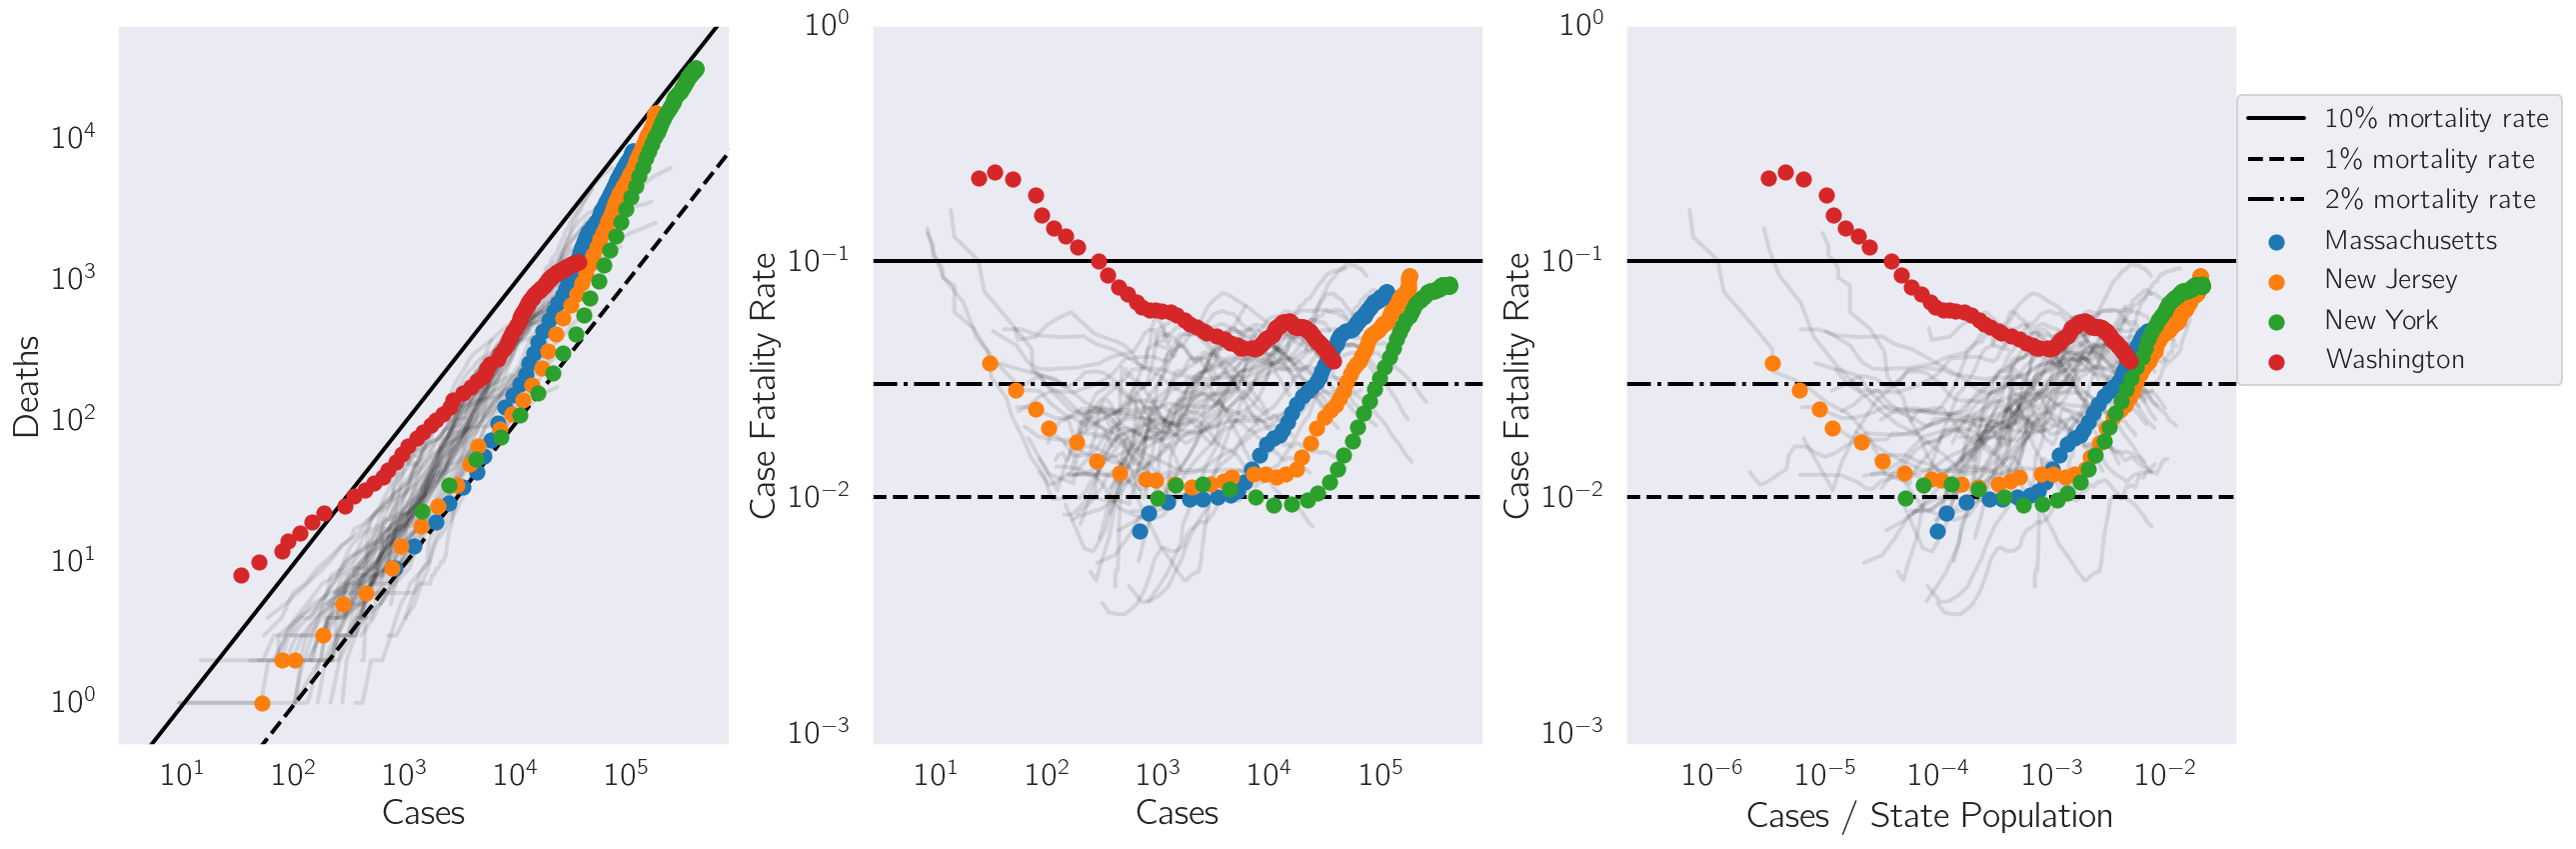

In [4]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))

ax[0] = cv.plot_cases_vs_deaths(df, xcol='cases', ycol='deaths', ax=ax[0])
ax[1] = cv.plot_cases_vs_deaths(df, CFR=True, ax=ax[1])
ax[2] = cv.plot_cases_vs_deaths(df, xcol='normedPopCases', ycol='normedPopDeaths', CFR=True, ax=ax[2])
_ = ax[2].legend(loc=(1, .5))
ax[2].set_xlabel('Cases / State Population')
plt.tight_layout()

## Total CFR by state

In the graph below, I plot the total CFR by state. I plot the minimum CFR per state, the maximum CFR, and the current CFR calculated on all deaths and cases to date.

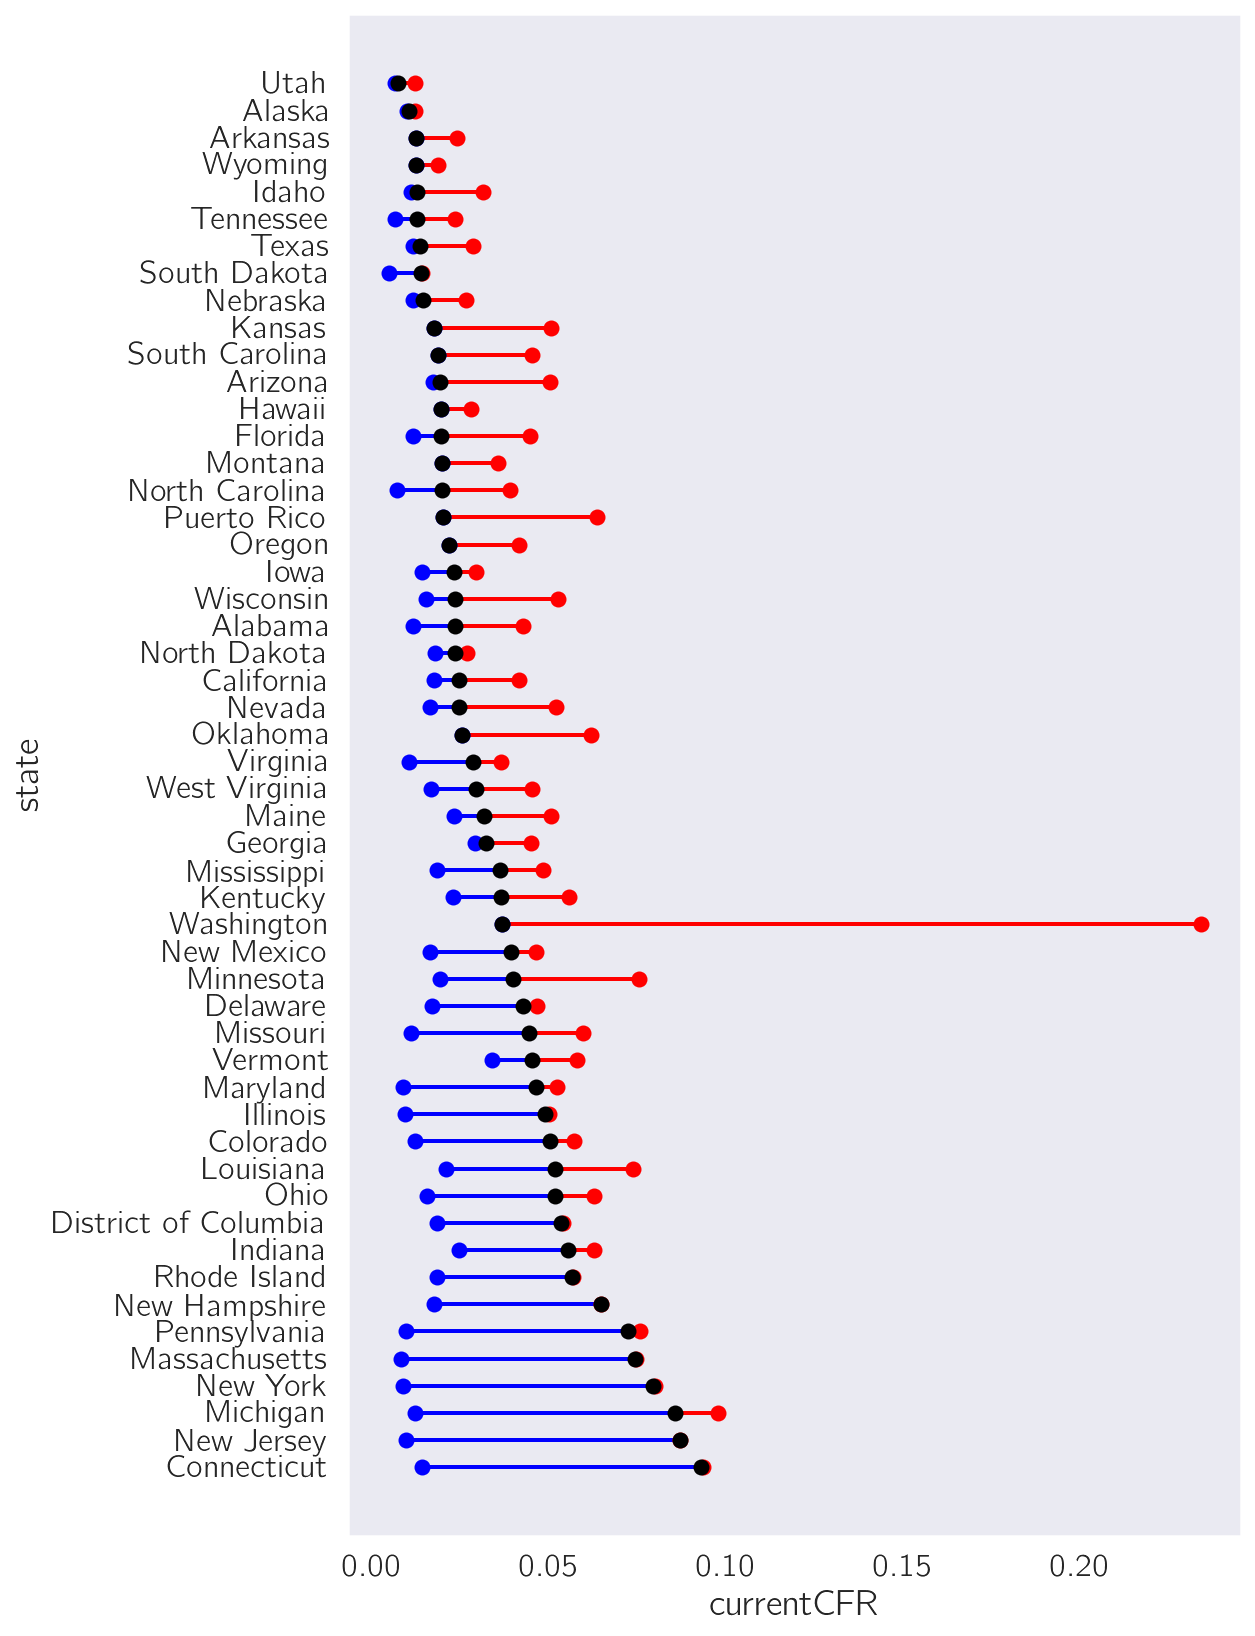

In [5]:
cfr = df[df.deaths > 10].groupby('state').apply(lambda x: x.deaths / x.cases, ).reset_index()
cfr.columns = ['state', 'level', 'CFR']
cfr_max_curr = cfr.groupby('state').CFR.agg([np.min, np.max, lambda x: x.tail(1)]).reset_index()
cfr_max_curr.columns = ['state', 'minCFR', 'maxCFR', 'currentCFR']
cfr_max_curr.sort_values('currentCFR', inplace=True)

fig, ax = plt.subplots(figsize=(8,14))
sns.stripplot(x='maxCFR', y='state', data=cfr_max_curr, color='red', s=8, jitter=False) 
sns.stripplot(x='minCFR', y='state', data=cfr_max_curr, color='blue', s=8, jitter=False) 
sns.stripplot(x='currentCFR', y='state', data=cfr_max_curr, color='black', s=8, jitter=False)
plt.errorbar(x=(cfr_max_curr.maxCFR + cfr_max_curr.currentCFR) / 2, y=cfr_max_curr.state,
             xerr=(cfr_max_curr.maxCFR - cfr_max_curr.currentCFR) / 2, fmt='none', color='red')
_ = plt.errorbar(x=(cfr_max_curr.minCFR + cfr_max_curr.currentCFR) / 2, y=cfr_max_curr.state,
                 xerr=(cfr_max_curr.minCFR - cfr_max_curr.currentCFR) / 2, fmt='none', color='blue')

# Epidemiological curves of COVID-19

I have plotted the cases and deaths through time in the plots below in *3 different ways*. The first column shows the absolute number of cases (first row) or deaths (second row). The second column shows the number of cases (deaths) normalized to the population of each state. The second column can be interpreted as your risk of getting COVID-19 through time for any given state, since it tells you the number of cases (or deaths) per million people for each state.

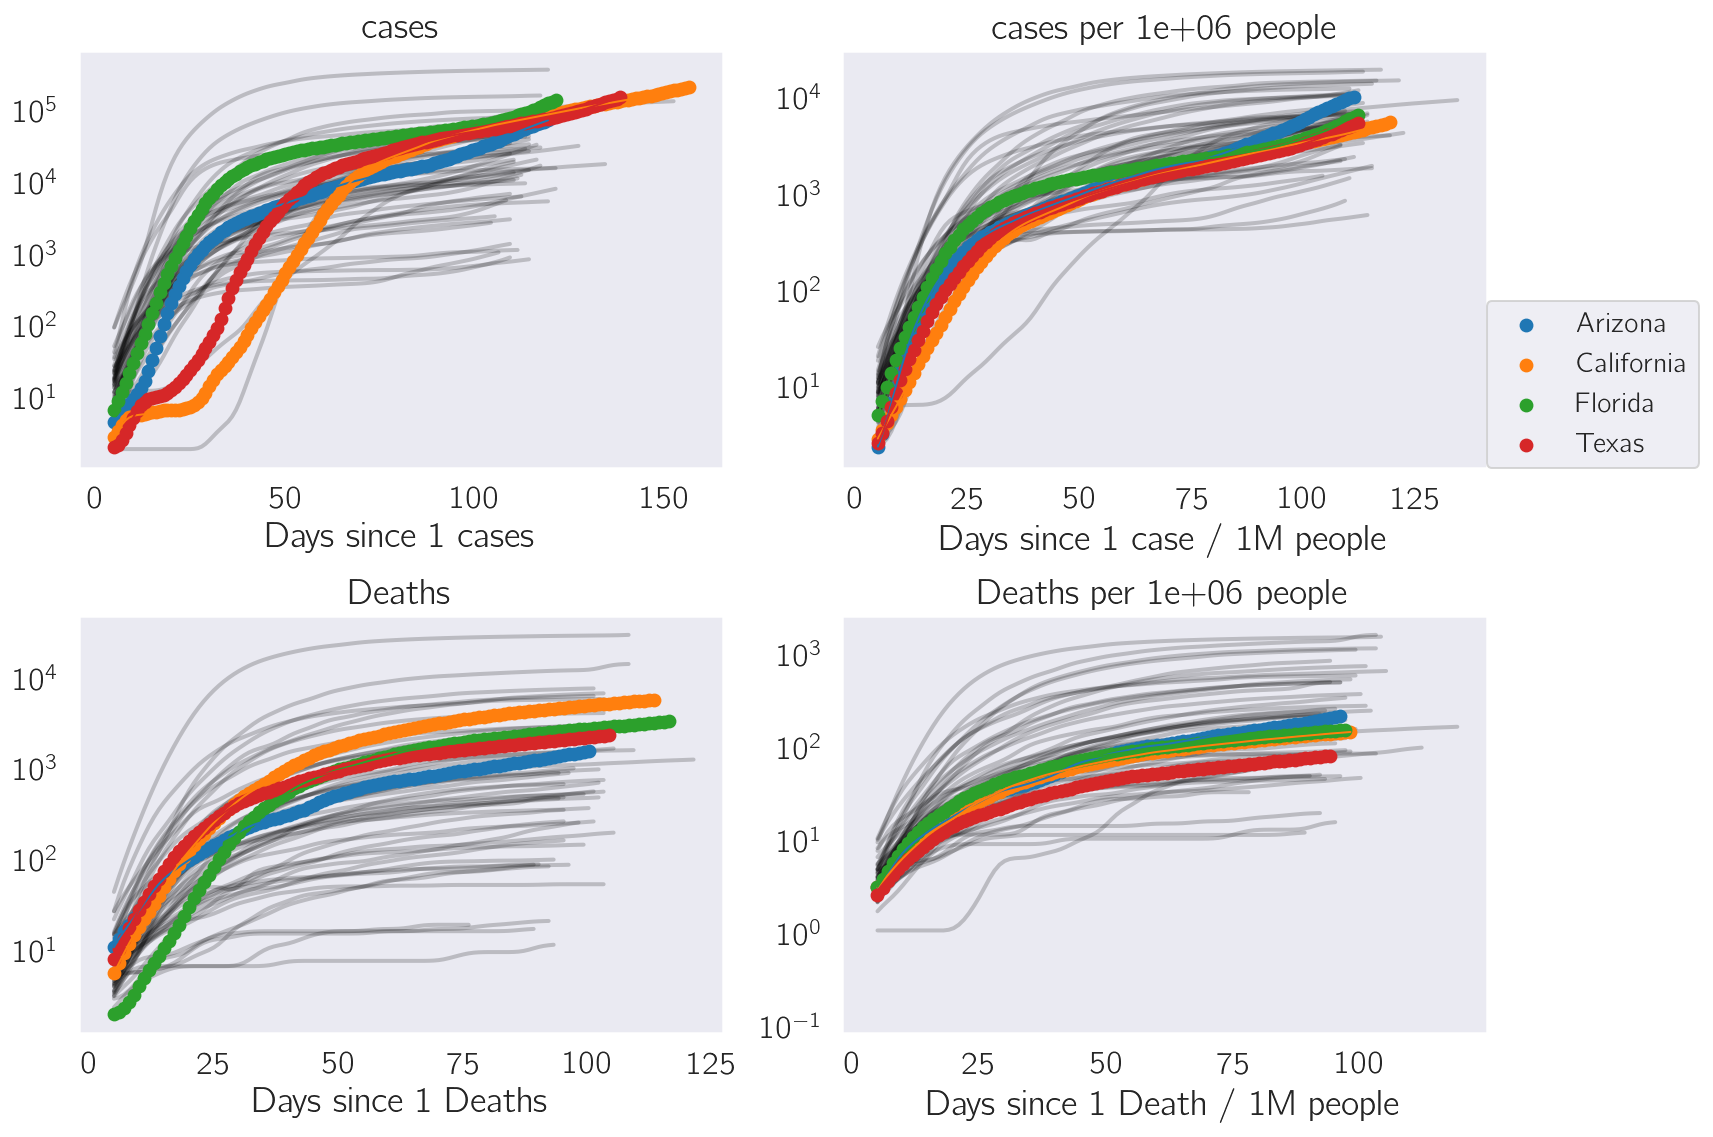

In [6]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
ax[0, :] = cv.plot(ax[0], df, 'cases', 'normedPopCases', n1=1, alpha=0.2 )
ax[1, :] = cv.plot(ax[1], df, 'deaths', 'normedPopDeaths',
                   1, 10 ** -6, ylab='Death', alpha=0.2)

for ai in ax:
    for aij in ai:
        aij.set_yscale('log')
_ = ax[0, 1].legend(loc=(1, 0))

plt.tight_layout()

# Are the curves flattening?

Notice that the case curves are on linear scale; the death curves are on log-scale.

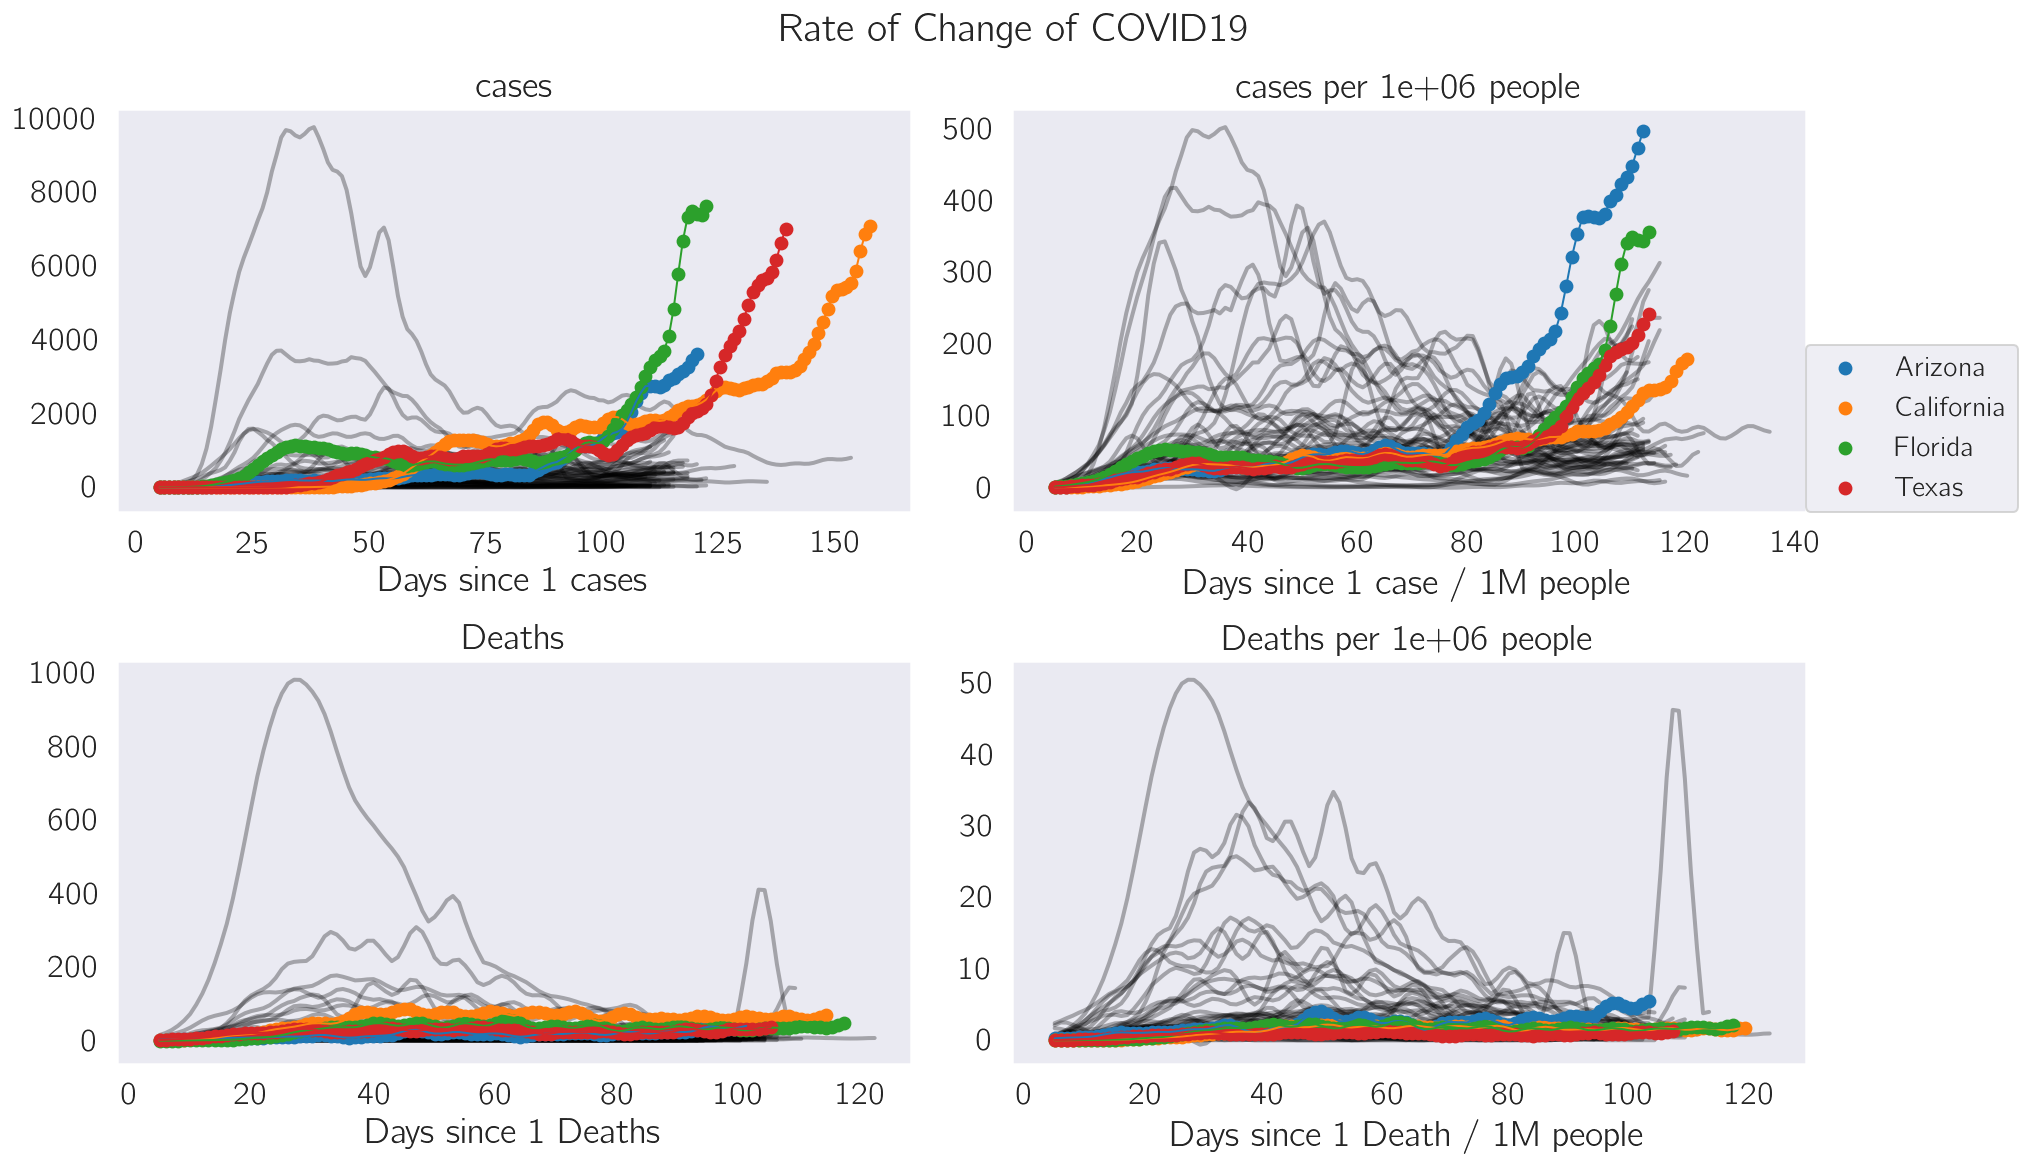

In [7]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14, 8), constrained_layout=True)

fig.suptitle('Rate of Change of COVID19', fontsize=20)
ax[0, :] = cv.plot(ax[0], df, 'cases', 'normedPopCases',  n1=1, gradient=True, window=8)
ax[1, :] = cv.plot(ax[1], df, 'deaths', 'normedPopDeaths',
                   1, 10 ** -8, ylab='Death', gradient=True, window=8)

# for ai in ax[1, :]:
#     ai.set_yscale('log')
_ = ax[0, 1].legend(loc=(1, 0))

Text(0, 0.5, 'Cases Per 1000 People / Day')

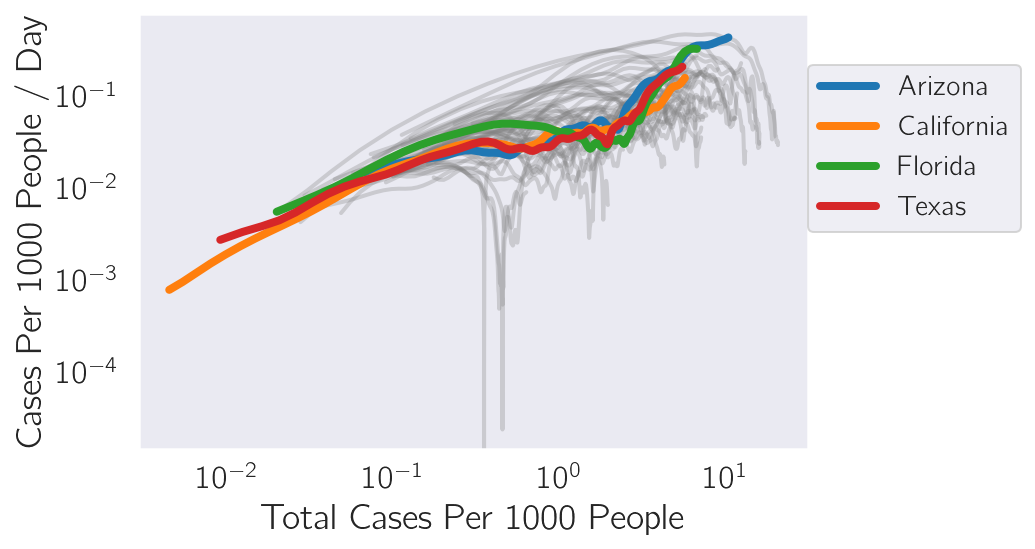

In [8]:
for n, g in df.groupby('state'):
    x = 1000 * g[g.cases > 50].normedPopCases.rolling(window=10, win_type='gaussian', center=True).mean(std=2)
    if n not in worst:
        plt.plot(x, np.gradient(x), color='gray', lw=2, alpha=0.3)
    else:
        plt.plot(x, np.gradient(x), label=n, lw=4, zorder=np.inf)

plt.xscale('log')
plt.yscale('log')
plt.legend(loc=(1, 0.5))
plt.xlabel('Total Cases Per 1000 People')
plt.ylabel('Cases Per 1000 People / Day')

Text(0, 0.5, 'Deaths Per 1000 People / Day')

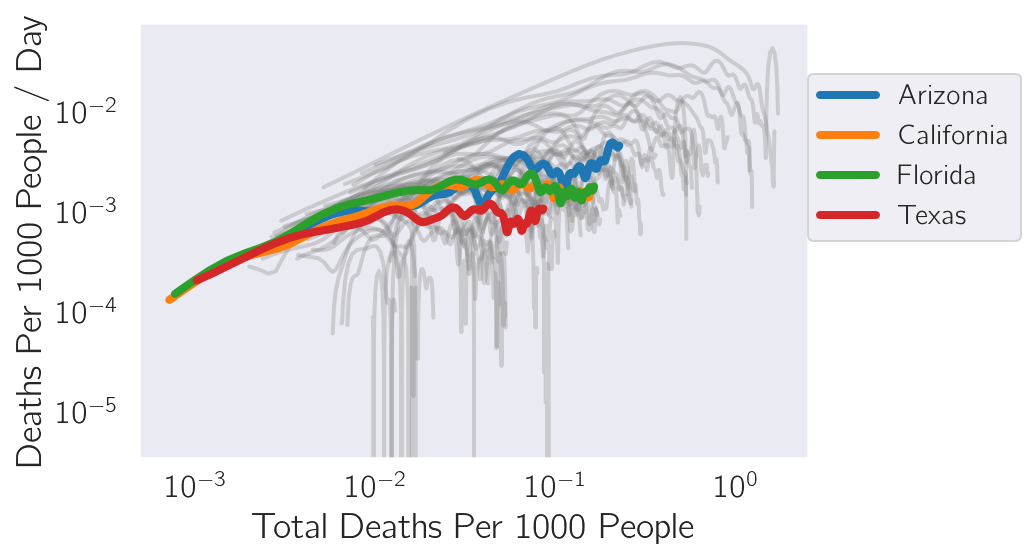

In [9]:
for n, g in df.groupby('state'):
    x = 1000 * g[g.deaths > 5].normedPopDeaths.rolling(window=10, win_type='gaussian', center=True).mean(std=2)
    if n not in worst:
        plt.plot(x, np.gradient(x), color='gray', lw=2, alpha=0.3)
    else:
        plt.plot(x, np.gradient(x), label=n, lw=4, zorder=np.inf)

plt.xscale('log')
plt.yscale('log')
plt.legend(loc=(1, 0.5))
plt.xlabel('Total Deaths Per 1000 People')
plt.ylabel('Deaths Per 1000 People / Day')

# When are the peaks happening?

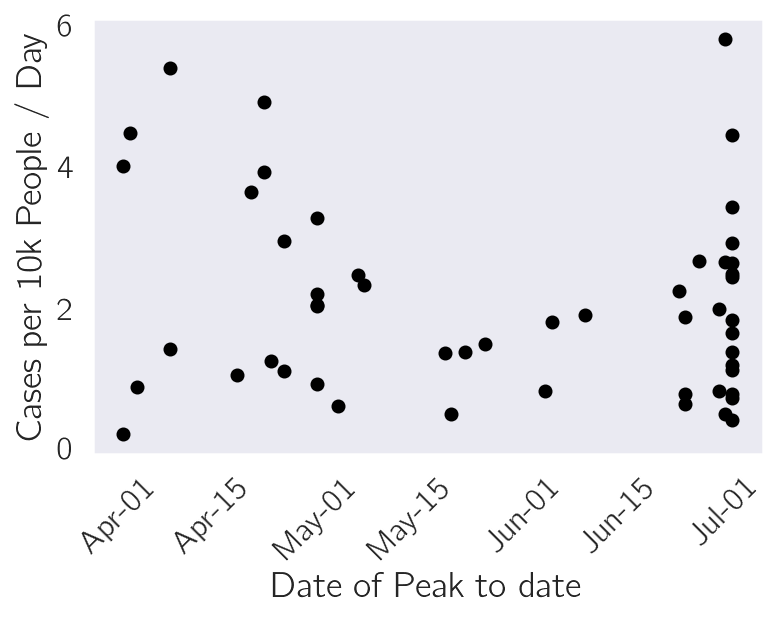

In [41]:
from matplotlib.dates import DateFormatter
df['SmoothCases'] = df.groupby('state').normedPopCases.apply(lambda x: x.rolling(window=3, win_type='gaussian', center=True).mean(std=2))
df['GradCases'] = df.groupby('state').SmoothCases.transform(np.gradient)
tmp = df.loc[df.groupby('state')['GradCases'].idxmax()].sort_values('date')

plt.plot(tmp.date, 10000 * tmp.GradCases, 'o', color='black')
date_form = DateFormatter("%b-%d")
plt.gca().xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45)
_ = plt.ylabel('Cases per 10k People / Day')
_ = plt.xlabel('Date of Peak to date')

Proportion of population in peaking states: 50%
Number of states peaking: 33


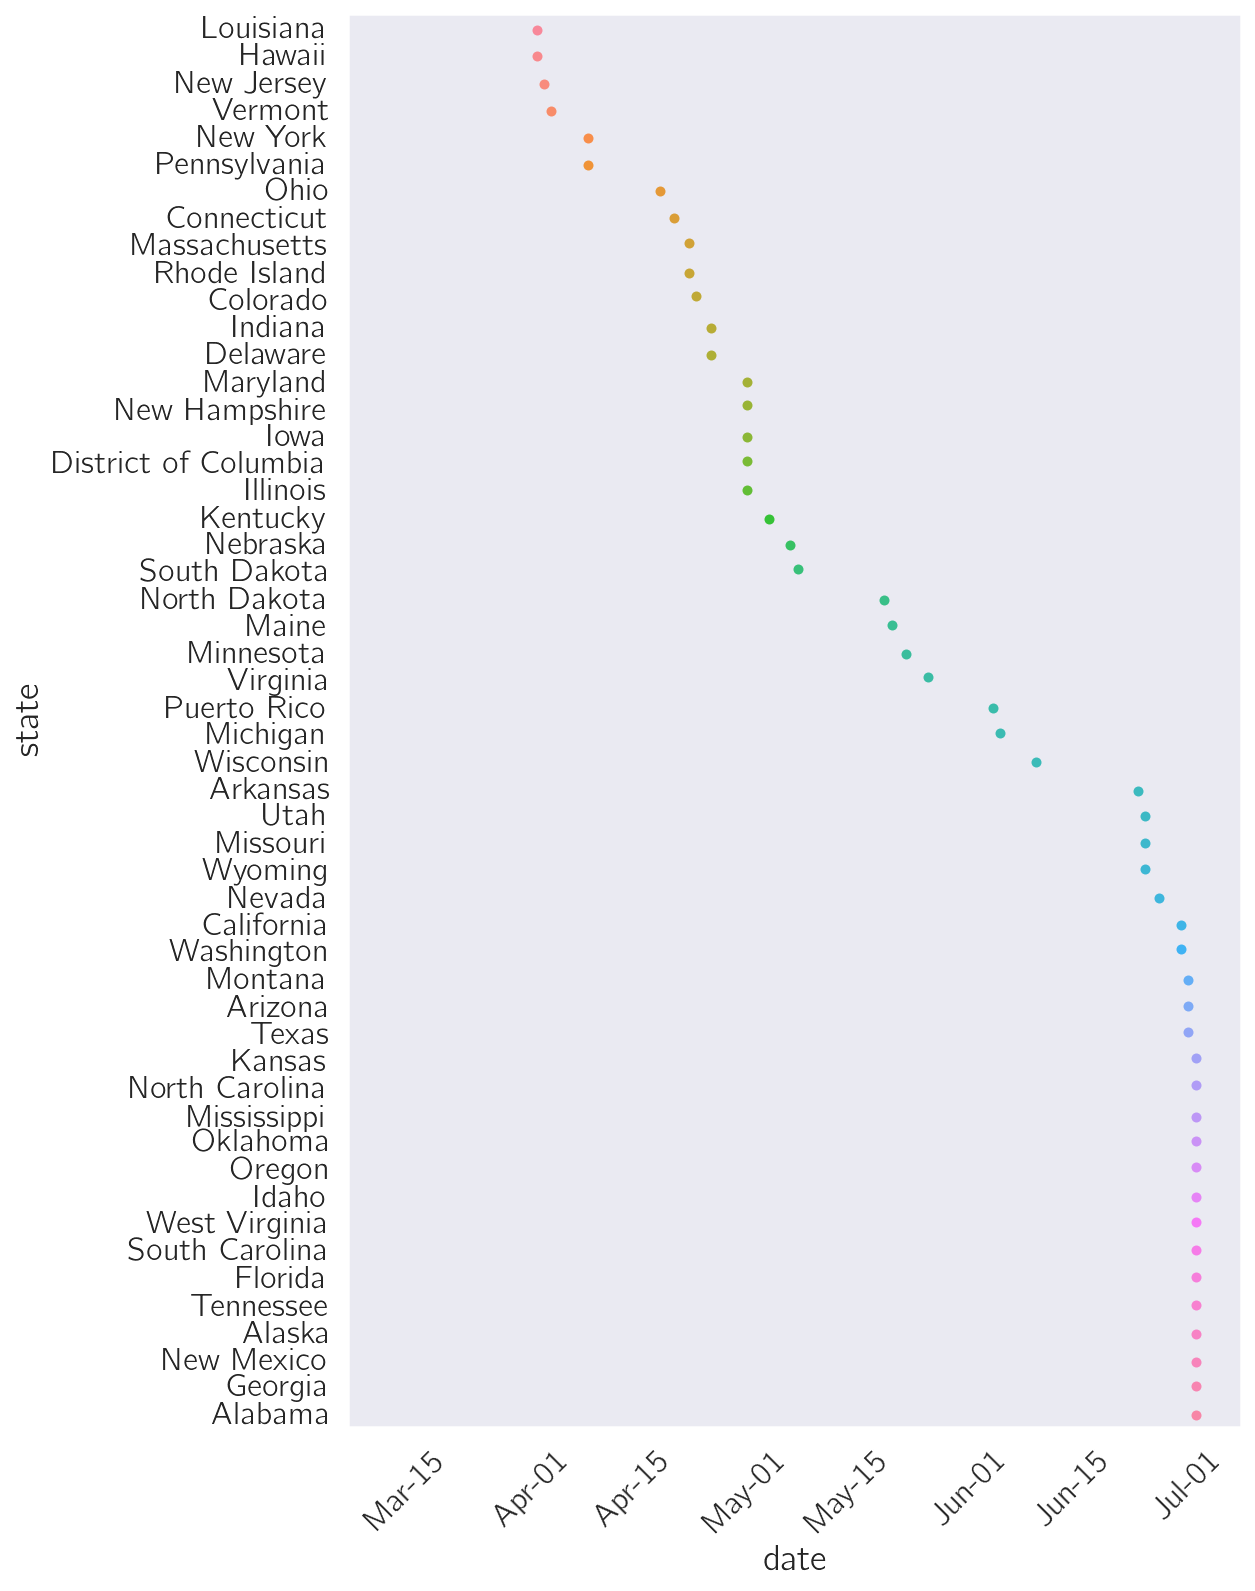

In [11]:
fig, ax = plt.subplots(figsize=(8,13))
sns.stripplot(x='date', y='state', data=tmp.sort_values('date'))
ax.xaxis.set_major_formatter(date_form)
_ = plt.xticks(rotation=45)

affected = tmp[tmp.date < dt.datetime.now() - dt.timedelta(days=7)]
print('Proportion of population in peaking states: {0:.2g}%'.format(affected[2019].sum() / tmp[2019].sum() * 100))
print('Number of states peaking: {0}'.format(len(affected)))

## What about in the US as a whole?

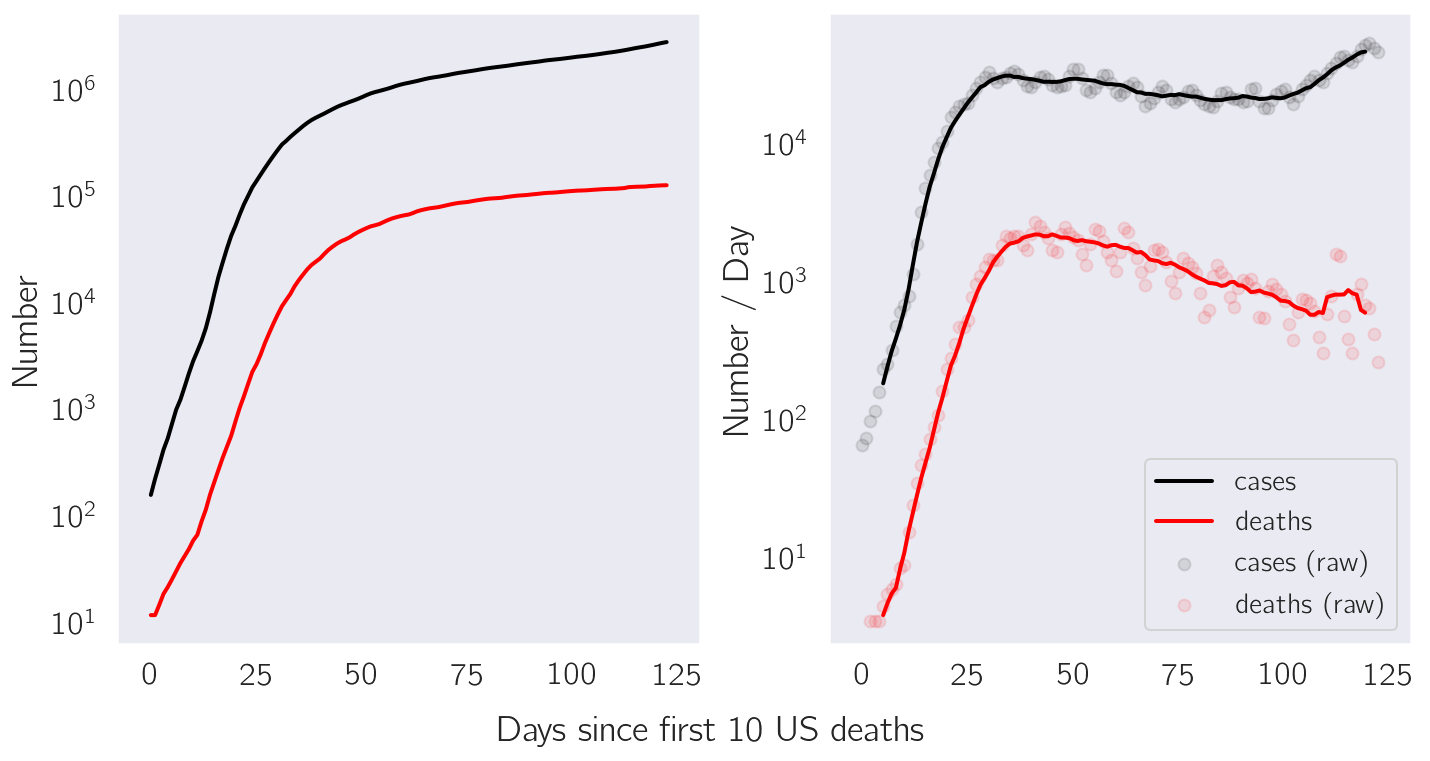

In [24]:
us  = df.groupby('date')[['cases', 'deaths']].sum().reset_index()
us = us[us.date >= us[us.deaths > 10].date.min()]
us['RefTime'] = (us.date - us.date.min()) / dt.timedelta(days=1)

fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(10, 5))

ax[0].plot(us.RefTime, us.cases, color='black', label='cases')
ax[0].plot(us.RefTime, us.deaths, color='red', label='deaths')
ax[1].plot(us.RefTime, us.cases.diff().rolling(win_type='exponential',
                                               window=8, center=True).mean(tau=10),
          color='black', label='cases')
ax[1].plot(us.RefTime, us.deaths.diff().rolling(win_type='exponential',
                                                window=8, center=True).mean(tau=10),
          color='red', label='deaths')

ax[1].scatter(us.RefTime, np.gradient(us.cases),
              color='black', label='cases (raw)', alpha=0.1)
ax[1].scatter(us.RefTime, np.gradient(us.deaths),
              color='red', label='deaths (raw)', alpha=0.1)

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_ylabel('Number')
ax[1].set_ylabel('Number / Day')
fig.text(0.5, -0.04, 'Days since first 10 US deaths',
         ha='center', fontsize=18)
plt.legend()
plt.tight_layout()

## What is the daily CFR through the pandemic?

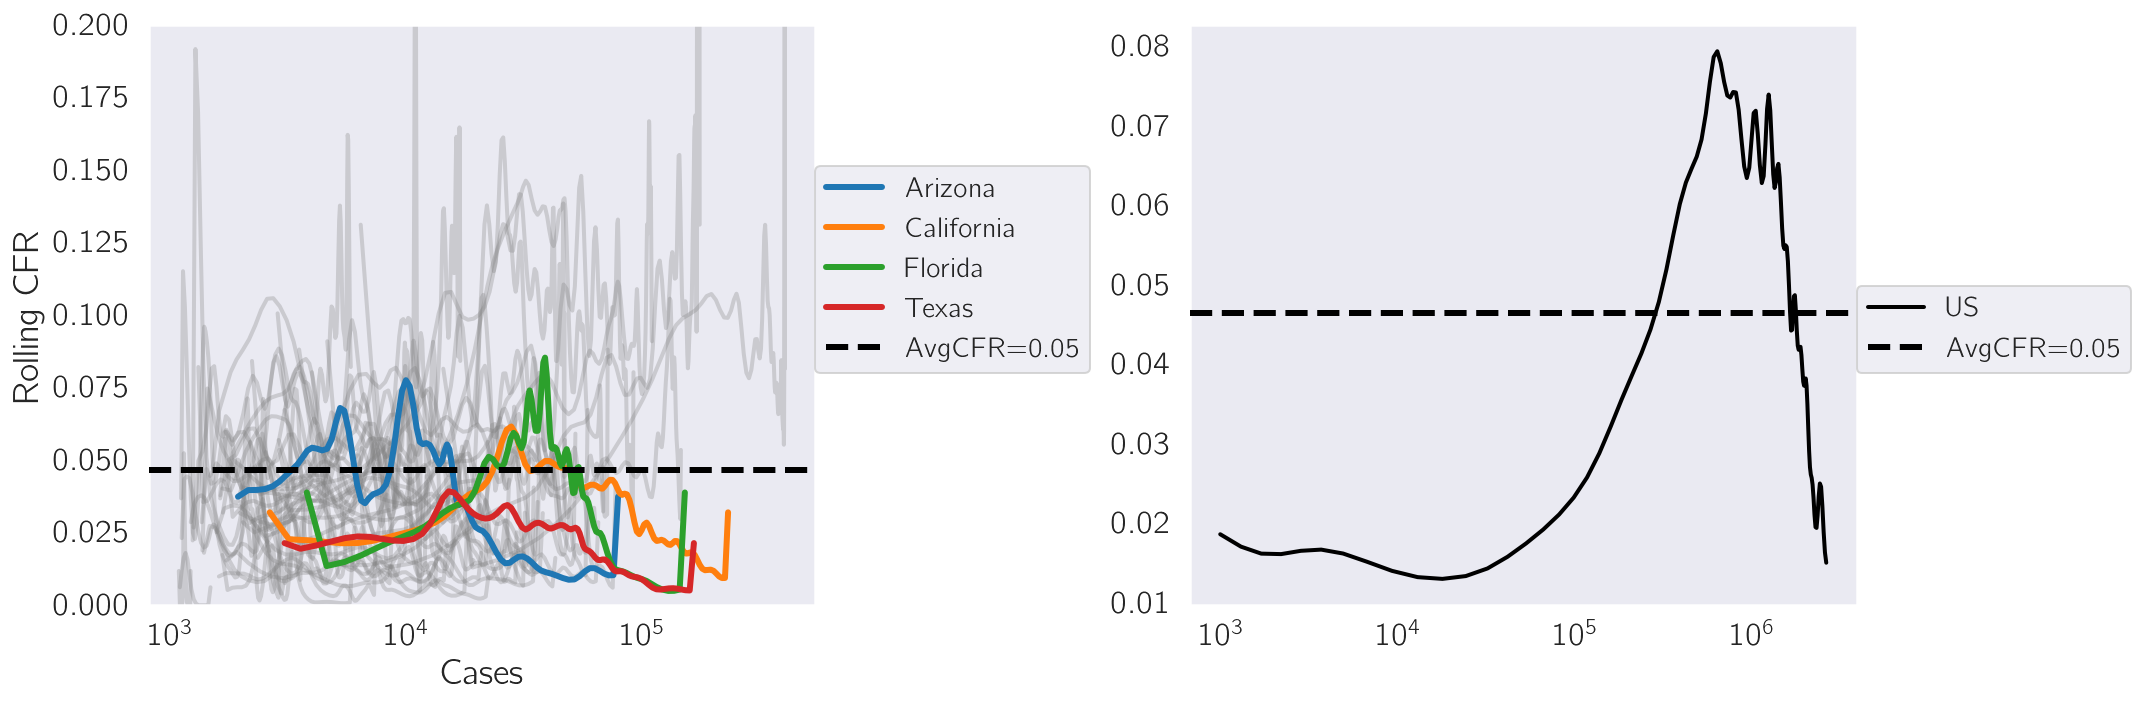

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
gradient = True
l = []
for n, g in df[df.cases > 1000].groupby('state'):
    if len(g) < 10:
        continue
    smoothD = g.deaths.rolling(window=10, win_type='gaussian',
                                        center=True).mean(std=2)
    smoothC = g.cases.rolling(window=10, win_type='gaussian',
                                       center=True).mean(std=2)
    gradD = np.gradient(smoothD)
    gradC = np.gradient(smoothC)
    y = (gradD / gradC)
    y[np.isnan(y)] = np.nanmean(y)
    y[y > 1] = 1
    if n not in worst:
        ax[0].plot(smoothC, y, '-', color='gray', alpha=0.3)
    else:
        ax[0].plot(smoothC, y, zorder=np.inf, lw=3, label=n)
    l += [yi for yi in y[~np.isnan(y)]]

# plot the CFR for the entire US:
ax[1].plot(us.cases.rolling(win_type='gaussian', window=10, center=True).mean(std=2),
           np.gradient(us.deaths.rolling(win_type='gaussian', window=10, center=True).mean(std=2)) /
           np.gradient(us.cases.rolling(win_type='gaussian', window=10, center=True).mean(std=2)),
           color='black', label='US')

# plot average of all time:
ax[0].axhline(np.nanmean(l), ls='--', color='black', lw=3,
            zorder=np.inf, label='AvgCFR={0:.1g}'.format(np.mean(l)))
ax[1].axhline(np.nanmean(l), ls='--', color='black', lw=3,
            zorder=np.inf, label='AvgCFR={0:.1g}'.format(np.mean(l)))

for ai in ax:
#     ai.set_yscale('log')
    ai.set_xscale('log')

ax[0].legend(loc=(1, 0.4))
ax[1].legend(loc=(1, 0.4))

ax[0].set_ylim(0, .2)
ax[0].set_xlabel('Cases')
_ = ax[0].set_ylabel('Rolling CFR')

plt.tight_layout()

# What states have the highest and lowest # of deaths per capita?

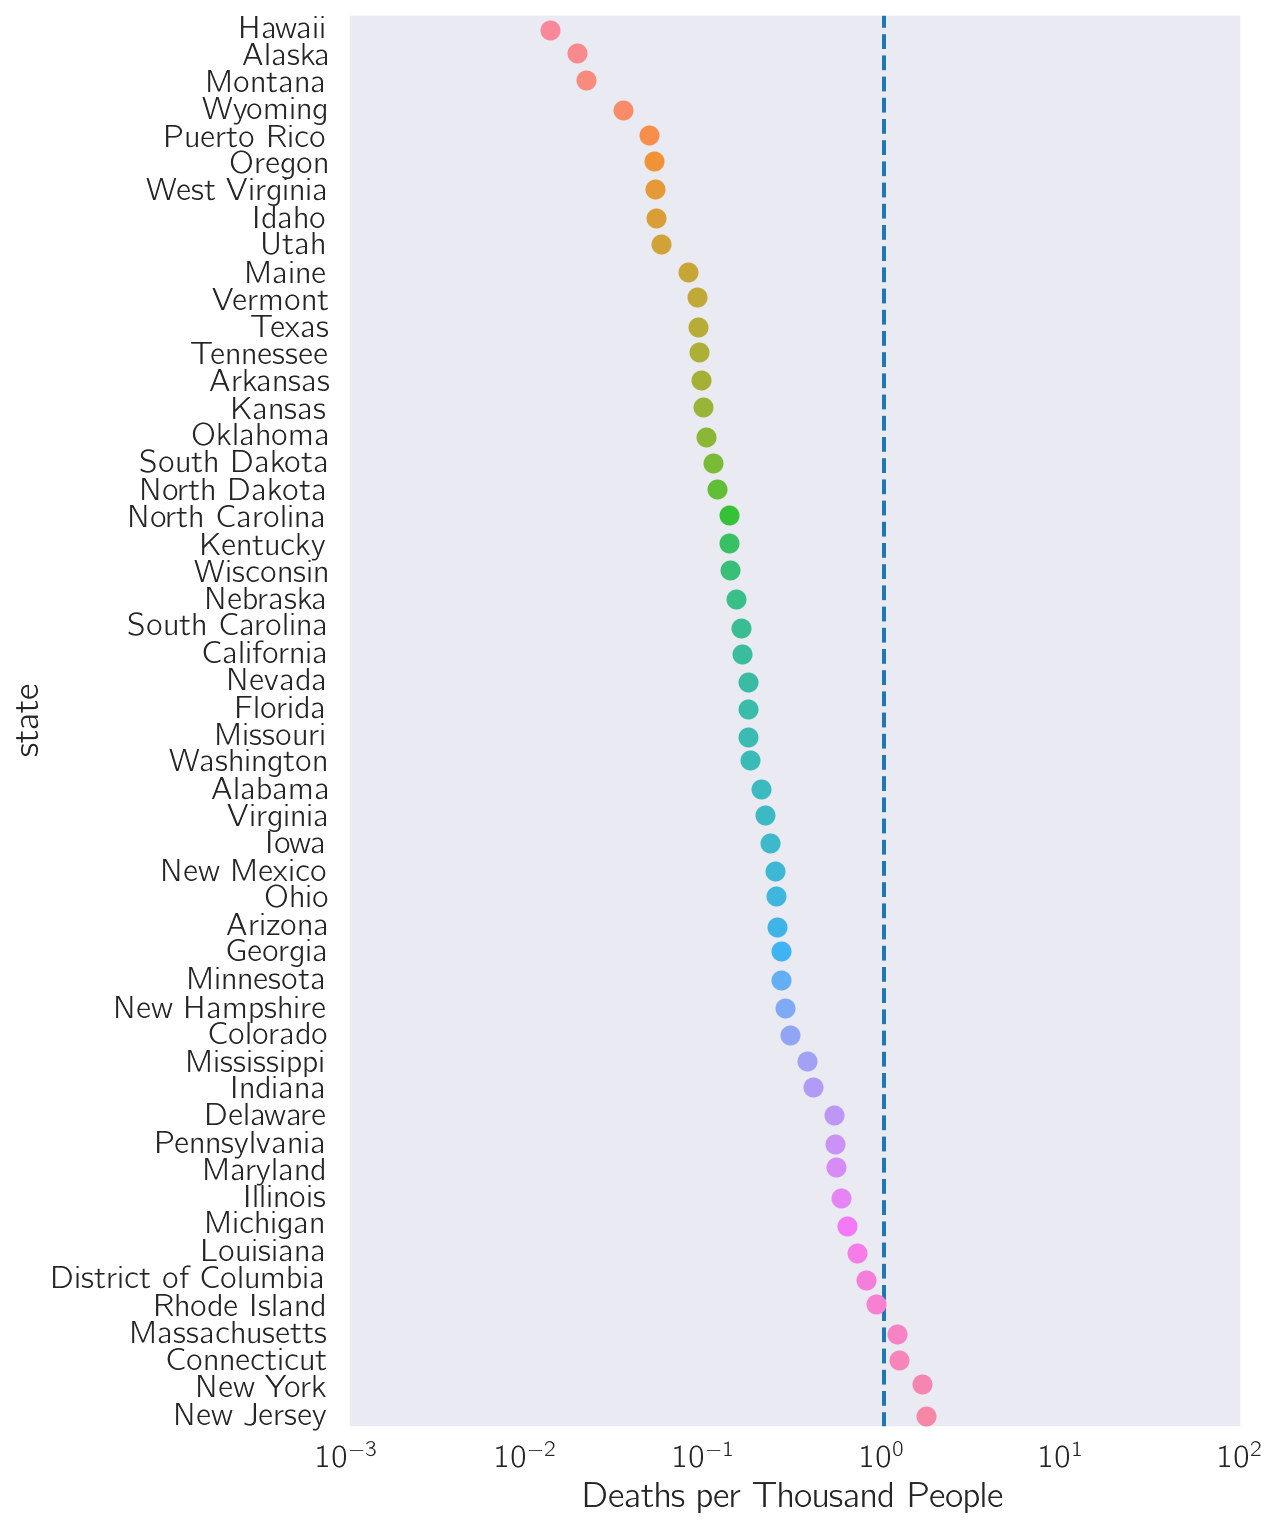

In [25]:
fig, ax = plt.subplots(figsize=(8,13))
tmp = df.groupby('state').normedPopDeaths.apply(np.max)
tmp = tmp.sort_values() 
sns.stripplot(x=tmp.sort_values() * 10 ** 3, y=tmp.index, size=10)
plt.axvline(1, ls='--')
plt.xlim(10**-3, 10**2)
plt.xlabel('Deaths per Thousand People')
plt.xscale('log')

# The viral reproductive viral, $R_t$, through time

Using this data, we can calculate the viral reproductive number through time. If we get $R_t < 1$, then that means the virus is dying out, whereas if it is above 1, the virus is growing.

I performed this analysis using the reported cases, but I also performed a second analysis using reported deaths. An $R_t$ based on deaths is meaningless from the point of view of quantitative interpretation, however, once we achieve $R_t < 1$ for a sufficient amount of time, we should see both curves dip below 1.

Here are the curves for four states:

./utils/covid_utils.py:281: RuntimeWarning: invalid value encountered in subtract
  p = np.exp(p - logsumexp(p)) * p_prev @ prior


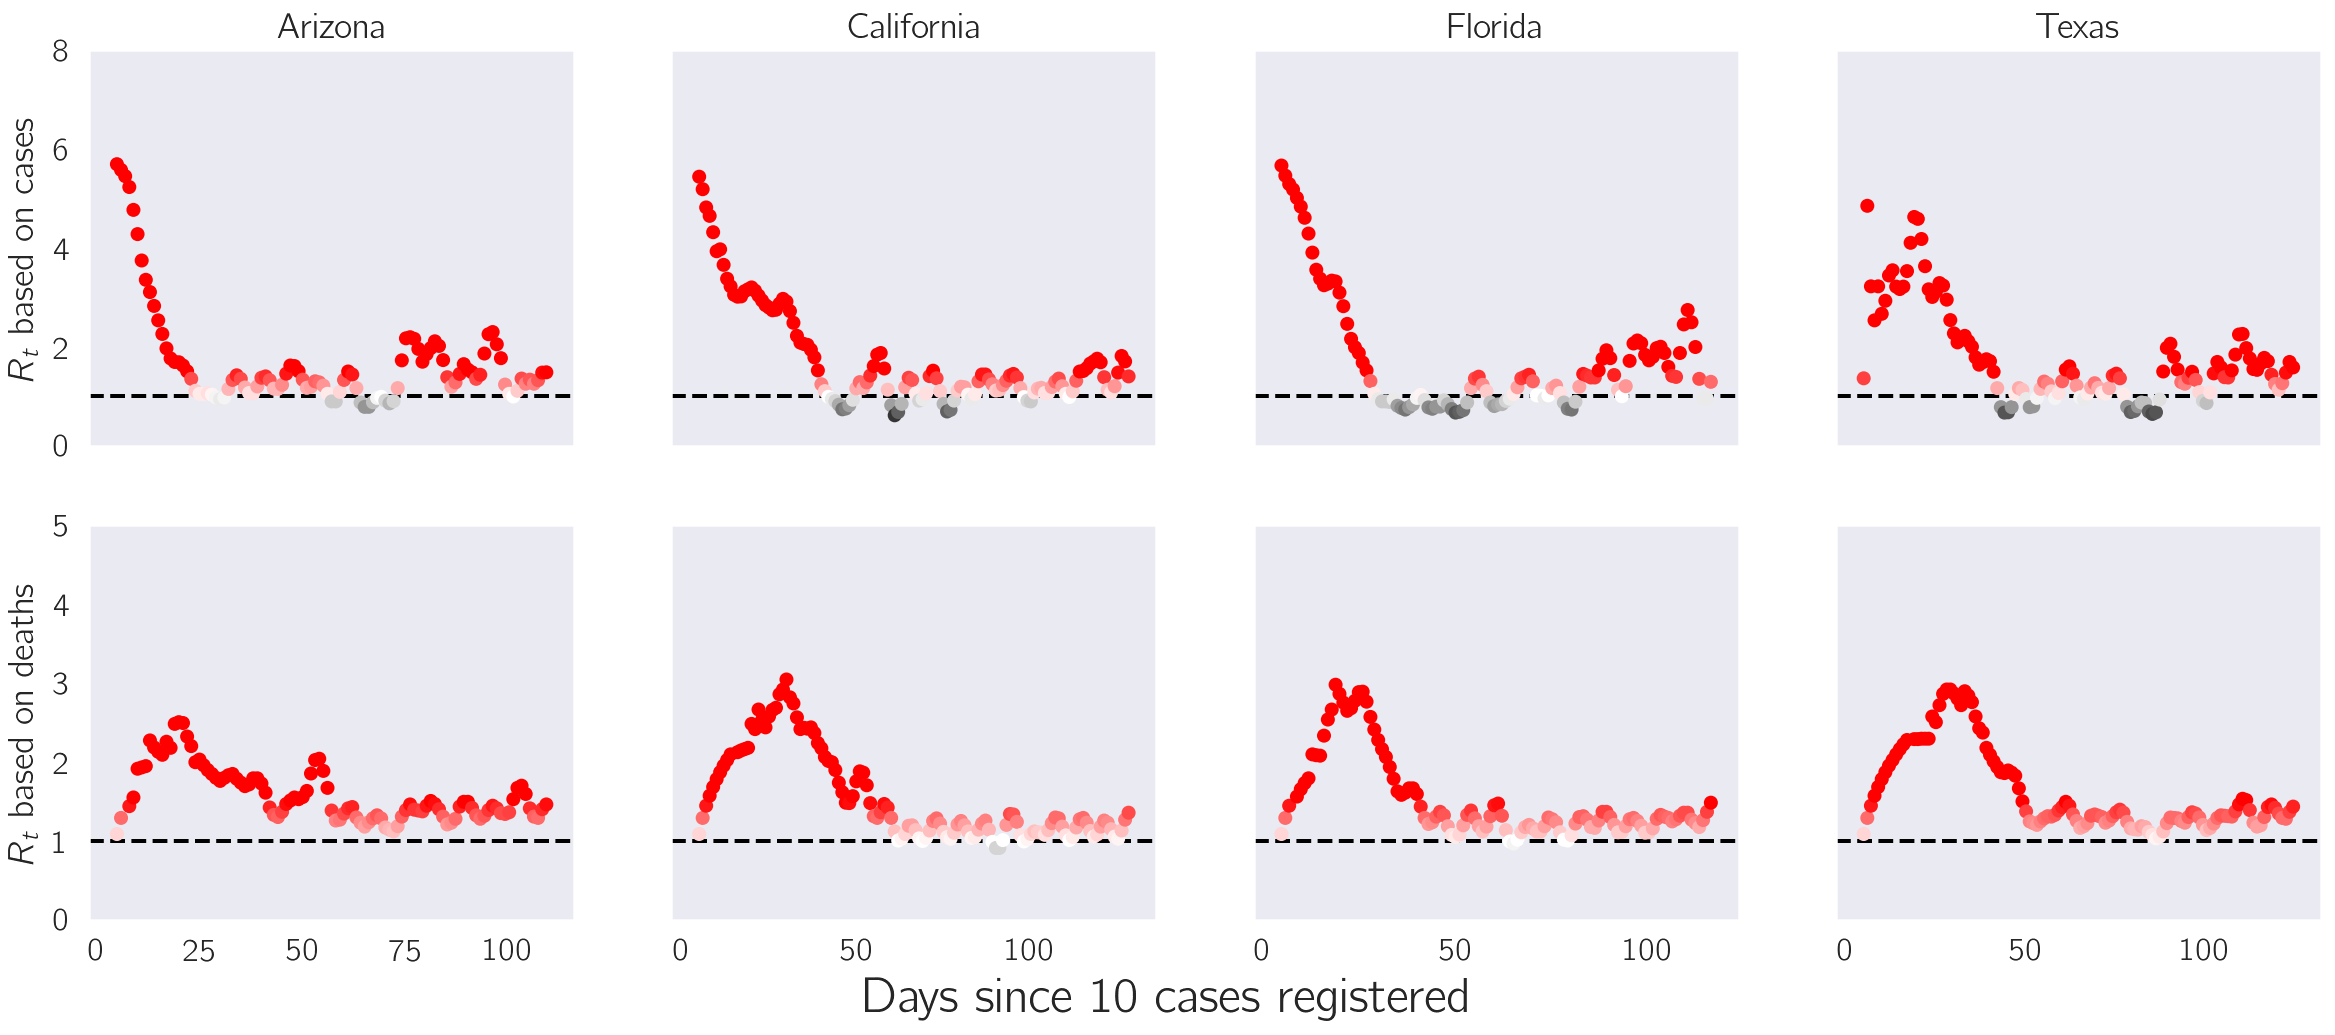

In [15]:
maxR = cv.plot_rt(worst, df, df.cases > 10)
_ = plt.figtext(.5, .045, 'Days since 10 cases registered', fontsize=25, ha='center')

# What are the states with the best or worst $R_t$?

In [16]:
rt = np.array([])
s = np.array([], dtype=object)
for n, g in df[df.date > dt.datetime(2020, 5, 15)].groupby('state'):
    gp = g.copy()
    gp['newCases'] = gp.cases.diff().rolling(window=8,
                                             win_type='gaussian',
                                             center=True).mean(std=2).round()
    gp['newDeaths'] = gp.deaths.diff().rolling(window=8,
                                               win_type='gaussian',
                                               center=True).mean(std=2).round()

    maxR = cv.r_calc(gp, gamma=1/10)
    seven_day_avg = np.mean(maxR[maxR > 0][-7:])
    s = np.append(n, s)
    rt = np.append(seven_day_avg, rt)

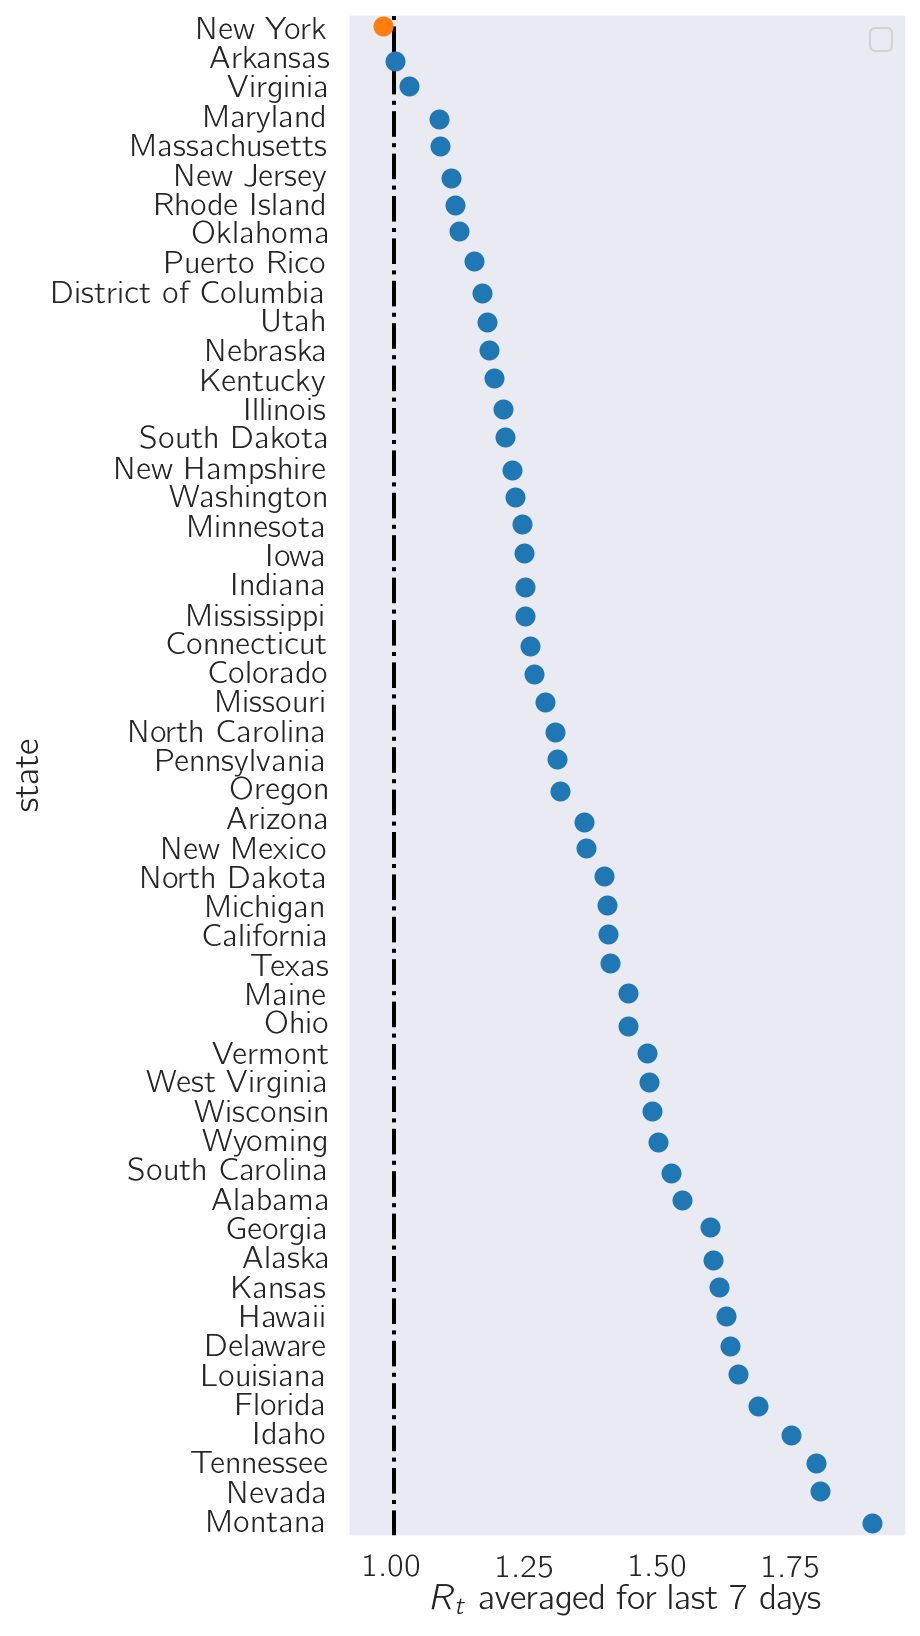

In [17]:
fig, ax = plt.subplots(figsize=(5, 14))
rdf = pd.DataFrame([s, rt]).transpose()
rdf.columns = ['state', 'r']
rdf['color'] = rdf.r < 1
sns.stripplot(y='state', x='r', hue='color', data=rdf.sort_values('r'), size=10)
plt.legend([])
plt.axvline(1, ls='-.', color='black')
_ = plt.xlabel(r'$R_t$ averaged for last 7 days')

Text(0, 0.5, 'Average $R_t$')

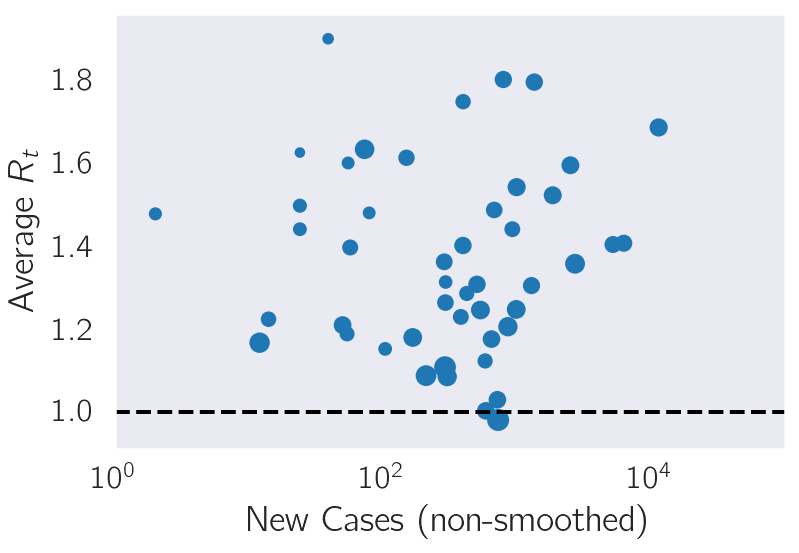

In [27]:
df['newCases'] = df.groupby('state').cases.diff()
tmp = df.groupby('state').last().merge(rdf, left_on='state', right_on='state')

active = (df.groupby('state').cases.last() - df.groupby('state').cases.nth(-10)).reset_index()
active['active'] = active.cases
active['activeNormed'] = (df.groupby('state').normedPopCases.last() - df.groupby('state').normedPopCases.nth(-10)).values

tmp = tmp.merge(active[['state', 'active', 'activeNormed']], left_on='state', right_on='state')
tmp.r = tmp.r.astype(np.float64)

plt.scatter(tmp.newCases, tmp.r, s=100 * np.sqrt(tmp.normedPopCases / tmp.normedPopCases.max()))

plt.xlim(1, 10 ** 5)
plt.axhline(1, ls='--', color='black')
plt.xscale('log')

plt.xlabel('New Cases (non-smoothed)')
plt.ylabel('Average $R_t$')

Text(0, 0.5, 'Average $R_t$')

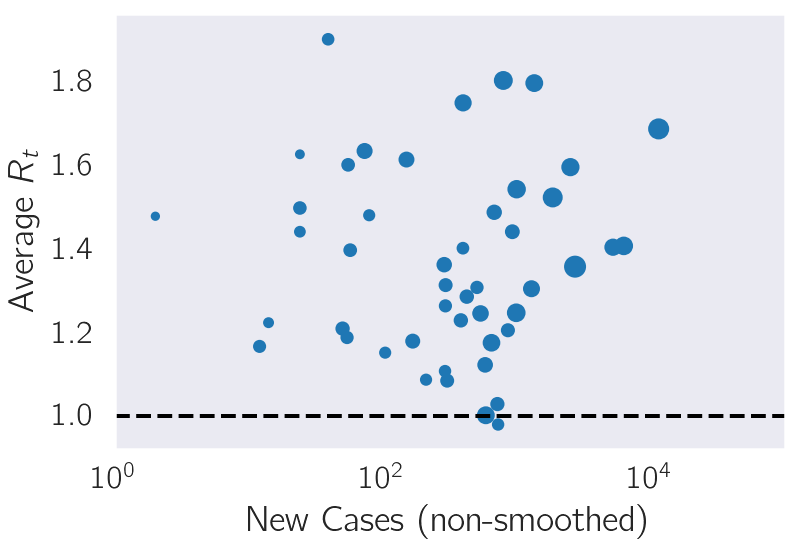

In [28]:
plt.scatter(tmp.newCases, tmp.r, s=100 * np.sqrt(tmp.activeNormed / tmp.activeNormed.max()))

plt.xlim(1, 10 ** 5)
plt.axhline(1, ls='--', color='black')
plt.xscale('log')

plt.xlabel('New Cases (non-smoothed)')
plt.ylabel('Average $R_t$')

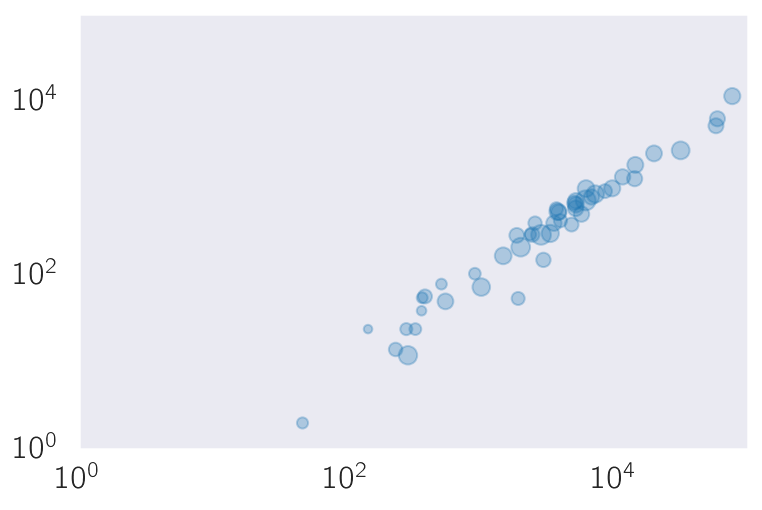

In [33]:
plt.scatter(tmp.active, tmp.newCases, s=100 * np.sqrt(tmp.normedPopCases / tmp.normedPopCases.max()), alpha=0.3)
plt.xlim(1, 10 ** 5)
plt.ylim(1, 10 ** 5)
plt.xscale('log')
plt.yscale('log')

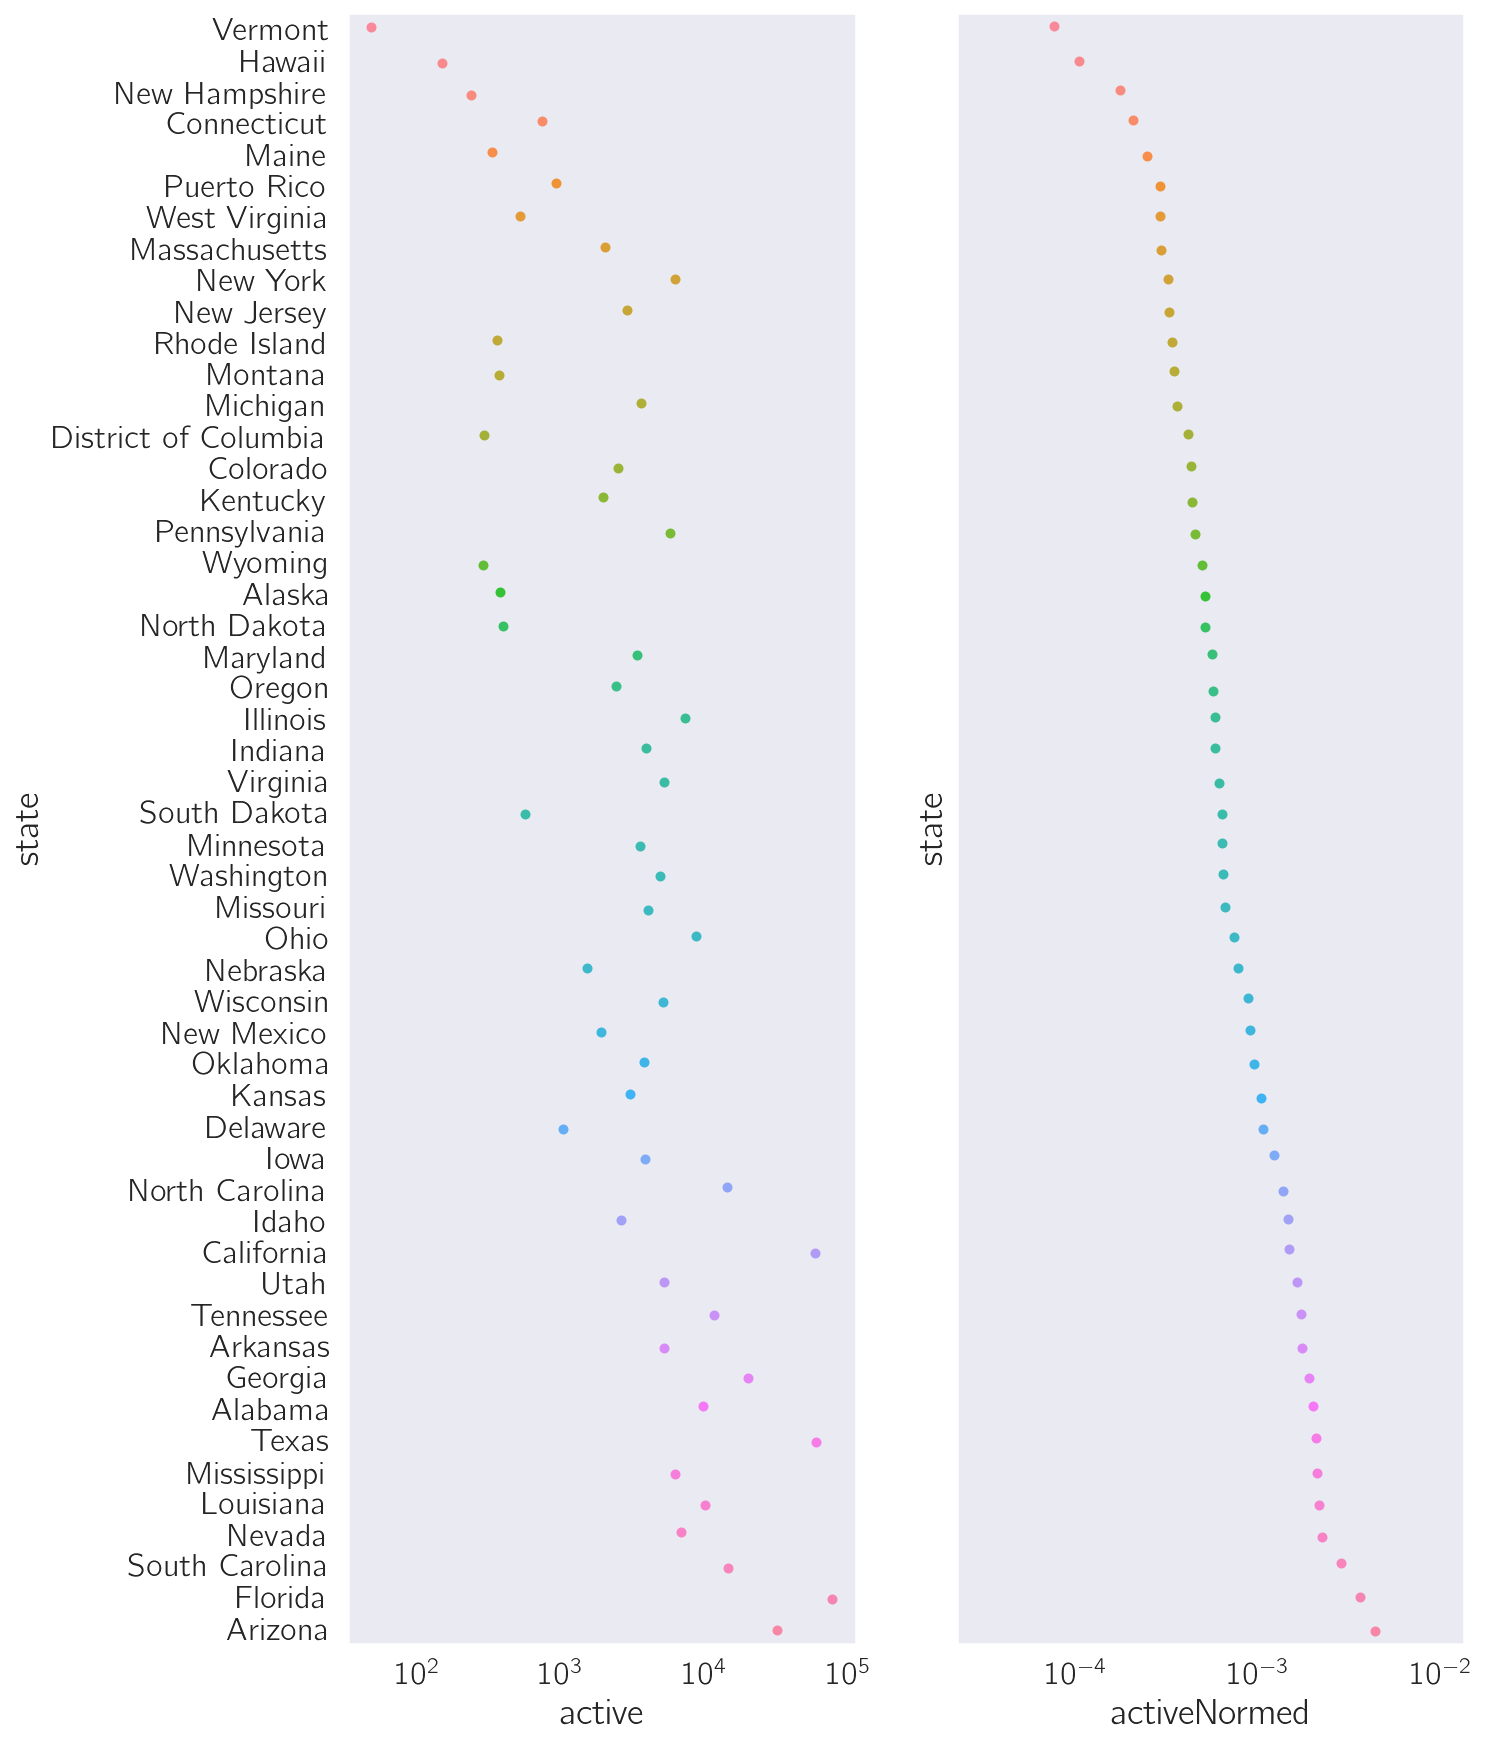

In [32]:
fig, ax = plt.subplots(figsize=(10, 15), ncols=2, sharey=True)
sns.stripplot(x='active', y='state', data=tmp.sort_values('activeNormed'), ax=ax[0])
sns.stripplot(x='activeNormed', y='state', data=tmp.sort_values('activeNormed'), ax=ax[1])
ax[0].set_xscale('log')
ax[1].set_xscale('log')